In [56]:
import os
import tensorflow as tf
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils.np_utils import to_categorical
from PIL import ImageColor
from Preprocessing.dataset import listSubFiles, groupPaths

# metadata
NUM_CLASSES = 48
X_TARGET_SHAPE = (256, 256, 1)

# hyperparams
EPOCHS = 50
BATCH_SIZE = 8

# Model definition

In [2]:

def ReduceBlock(inputs, features, dropout=0.3):
    # fmt: off
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    maxp = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(conv)
    # fmt: on
    return conv, maxp


def ExpandBlock(inputs, features, concatenate_with):
    # fmt: off
    upsa = tf.keras.layers.Conv2DTranspose(features, (2, 2), strides=(2, 2), padding="same")(inputs)
    upsa = tf.keras.layers.concatenate([upsa, concatenate_with])
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upsa)
    conv = tf.keras.layers.Dropout(0.3)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    # fmt: on
    return upsa, conv


def Unet(num_classes, input_shape=(128, 128, 1)):

    inputs = tf.keras.layers.Input(input_shape)
    bn = tf.keras.layers.BatchNormalization()(inputs)

    # Contraction path
    c1, p1 = ReduceBlock(bn, 16, dropout=0.1)
    c2, p2 = ReduceBlock(p1, 32, dropout=0.1)
    c3, p3 = ReduceBlock(p2, 64, dropout=0.1)
    c4, _ = ReduceBlock(p3, 128, dropout=0.1)

    # Expansion path
    u7, c7 = ExpandBlock(c4, 64, concatenate_with=c3)
    u8, c8 = ExpandBlock(c3, 32, concatenate_with=c2)
    u9, c9 = ExpandBlock(c8, 16, concatenate_with=c1)

    outputs = tf.keras.layers.Conv2D(num_classes + 1, (1, 1), activation="softmax")(c9)
    return inputs, outputs


tf.keras.backend.clear_session()
inputs, outputs = Unet(NUM_CLASSES, X_TARGET_SHAPE)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['batch_normalization[0][0]']    
                                )                                                             

# Dataset

In [3]:
DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet")

paths = listSubFiles(DATASET_PATH, depth=3)
test, train = groupPaths(paths, 2)
train_x, train_y = groupPaths(train, 1)

train_y_onehot = [file for file in train_y if file.endswith("_int.png")]
train_y_multihot = [file for file in train_y if file.endswith(".npy")]

train_x[0], train_y_onehot[0], train_y_multihot[0]

('..\\..\\datasets\\generated\\unet\\train\\x\\001.png',
 '..\\..\\datasets\\generated\\unet\\train\\y\\001_int.png',
 '..\\..\\datasets\\generated\\unet\\train\\y\\001.npy')

In [4]:
class Samples(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, num_classes, x_paths, y_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_x_paths = self.x_paths[i:i + self.batch_size]
        batch_y_paths = self.y_paths[i:i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, x_path in enumerate(batch_x_paths):
            x[j] = 255 - cv2.imread(x_path, cv2.IMREAD_GRAYSCALE)[..., None]
        y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes + 1,), dtype=np.uint8)
        # y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes,), dtype=np.float32)
        for j, y_path in enumerate(batch_y_paths):
            # y[j] = np.load(y_path)
            img = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
            y[j] = to_categorical(img, self.num_classes + 1)
        return x, y
        

In [5]:
random.Random(1337).shuffle(train_x)
random.Random(1337).shuffle(train_y_onehot)

val_split = 0.1
n_valid = int(val_split * len(train_x))
n_train = len(train_x) - n_valid

train_gen = Samples(1, (256, 256), 48, train_x[:n_train], train_y_onehot[:n_train])
valid_gen = Samples(1, (256, 256), 48, train_x[n_train:], train_y_onehot[n_train:])

((1, 256, 256, 1), (1, 256, 256, 49), dtype('uint8'), dtype('uint8'))

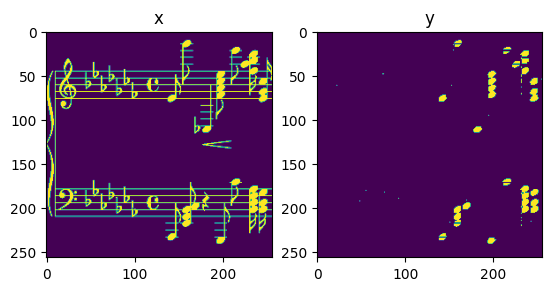

In [26]:
x, y = train_gen.__getitem__(0)

# y_vis = np.any(y[0] > 0, axis=2)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0])
axs[1].imshow(np.argmax(y[0], axis=2)==8)
axs[0].set_title("x")
axs[1].set_title("y")
x.shape, y.shape, y.dtype, x.dtype

# Training

In [7]:
MODEL_FILENAME = "test3.h5"

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=13),
    tf.keras.callbacks.ModelCheckpoint(
        MODEL_FILENAME,
        verbose=1,
        mode="min",
        save_best_only=True,
        monitor="val_loss",
    ),
    tf.keras.callbacks.TensorBoard(),
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/50
804/804 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.9060
Epoch 1: val_loss improved from inf to 0.30564, saving model to test3.h5
804/804 [==============================] - 52s 55ms/step - loss: 0.4273 - accuracy: 0.9060 - val_loss: 0.3056 - val_accuracy: 0.9232
Epoch 2/50
804/804 [==============================] - ETA: 0s - loss: 0.2971 - accuracy: 0.9260
Epoch 2: val_loss improved from 0.30564 to 0.25038, saving model to test3.h5
804/804 [==============================] - 28s 34ms/step - loss: 0.2971 - accuracy: 0.9260 - val_loss: 0.2504 - val_accuracy: 0.9317
Epoch 3/50
804/804 [==============================] - ETA: 0s - loss: 0.2539 - accuracy: 0.9326
Epoch 3: val_loss improved from 0.25038 to 0.21268, saving model to test3.h5
804/804 [==============================] - 27s 33ms/step - loss: 0.2539 - accuracy: 0.9326 - val_loss: 0.2127 - val_accuracy: 0.9379
Epoch 4/50
803/804 [============================>.] - ETA: 0s - loss: 0.2265 - accurac

# Test the model

1/1 [==============================] - 0s 302ms/step


array([ 0,  1,  2,  3,  6,  7,  8,  9, 12, 13, 14, 16, 17, 22, 23, 26, 28,
       29, 30, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48], dtype=int64)

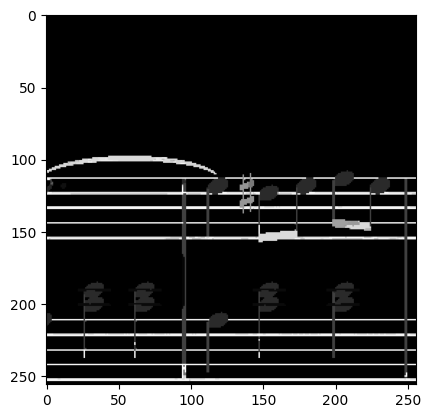

In [21]:
model = tf.keras.models.load_model('test3.h5')

img = cv2.imread("../../datasets/samples/sample_001.png", cv2.IMREAD_GRAYSCALE)
img = np.array((img - np.mean(img)) / np.std(img)).astype(np.uint8)

x, y = 200, 200
pred = model.predict(img[None, x:x+256, y:y+256, None])[0]

plt.imshow(np.argmax(pred, axis=2),cmap="gray")
np.unique(np.argmax(pred, axis=2))
# plt.imshow(pred[..., 11])
# np.mean(pred[..., 13])

0.0014533524

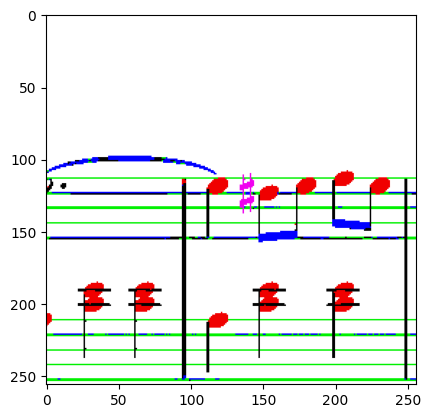

In [70]:
res = 255 - cv2.cvtColor(img[x:x+256, y:y+256, None], cv2.COLOR_GRAY2RGB)

colorings = {
    "#00f000": [46],
    "#0000ff": [41, 42, 40, 29, 30],
    "#f00000": [8],
    # "#f0f000": [29, 30],
    "#f000f0": [28, 23],
}

for color in colorings:
    labels = colorings[color]
    masks = [np.argmax(pred, axis=2)==l for l in labels]
    for mask in masks:
        res[mask] = ImageColor.getcolor(color, 'RGB')
plt.imshow(res)

target_label = 28
# plt.imshow(np.argmax(pred, axis=2)==target_label)
# plt.imshow(pred[..., target_label], cmap="gray")
np.mean(pred[..., target_label])
